In [2]:
%matplotlib inline
import os
import time
import h5py
import pygpc
import warnings
import numpy as np
import matplotlib.cbook
import matplotlib.pyplot as plt
from collections import OrderedDict
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Tutorial: Uncertainty and Sensitivity Analysis using Generalized Polynomial Chaos and pygpc

This tutorial shows you how to perform an uncertainty and sensitivity analysis using pygpc. The following topics will be discussed:
1. Introduction to uncertainty and sensitivity analysis
2. Introduction to generalized polynomial chaos
3. How to create your own gPC

## Part 1: Introduction to uncertainty and sensitivity analysis and generalized polynomial chaos

Typically, we have some model, which depends on parameters, e.g., $\tau_{e,i}$, $\tau_{e,i}$, $...$, $C_i$ and we are interested in several quantities of interest (QOI), e.g., $\mathbf{y}$, we can compute, when we run the model with the desired set of parameters.

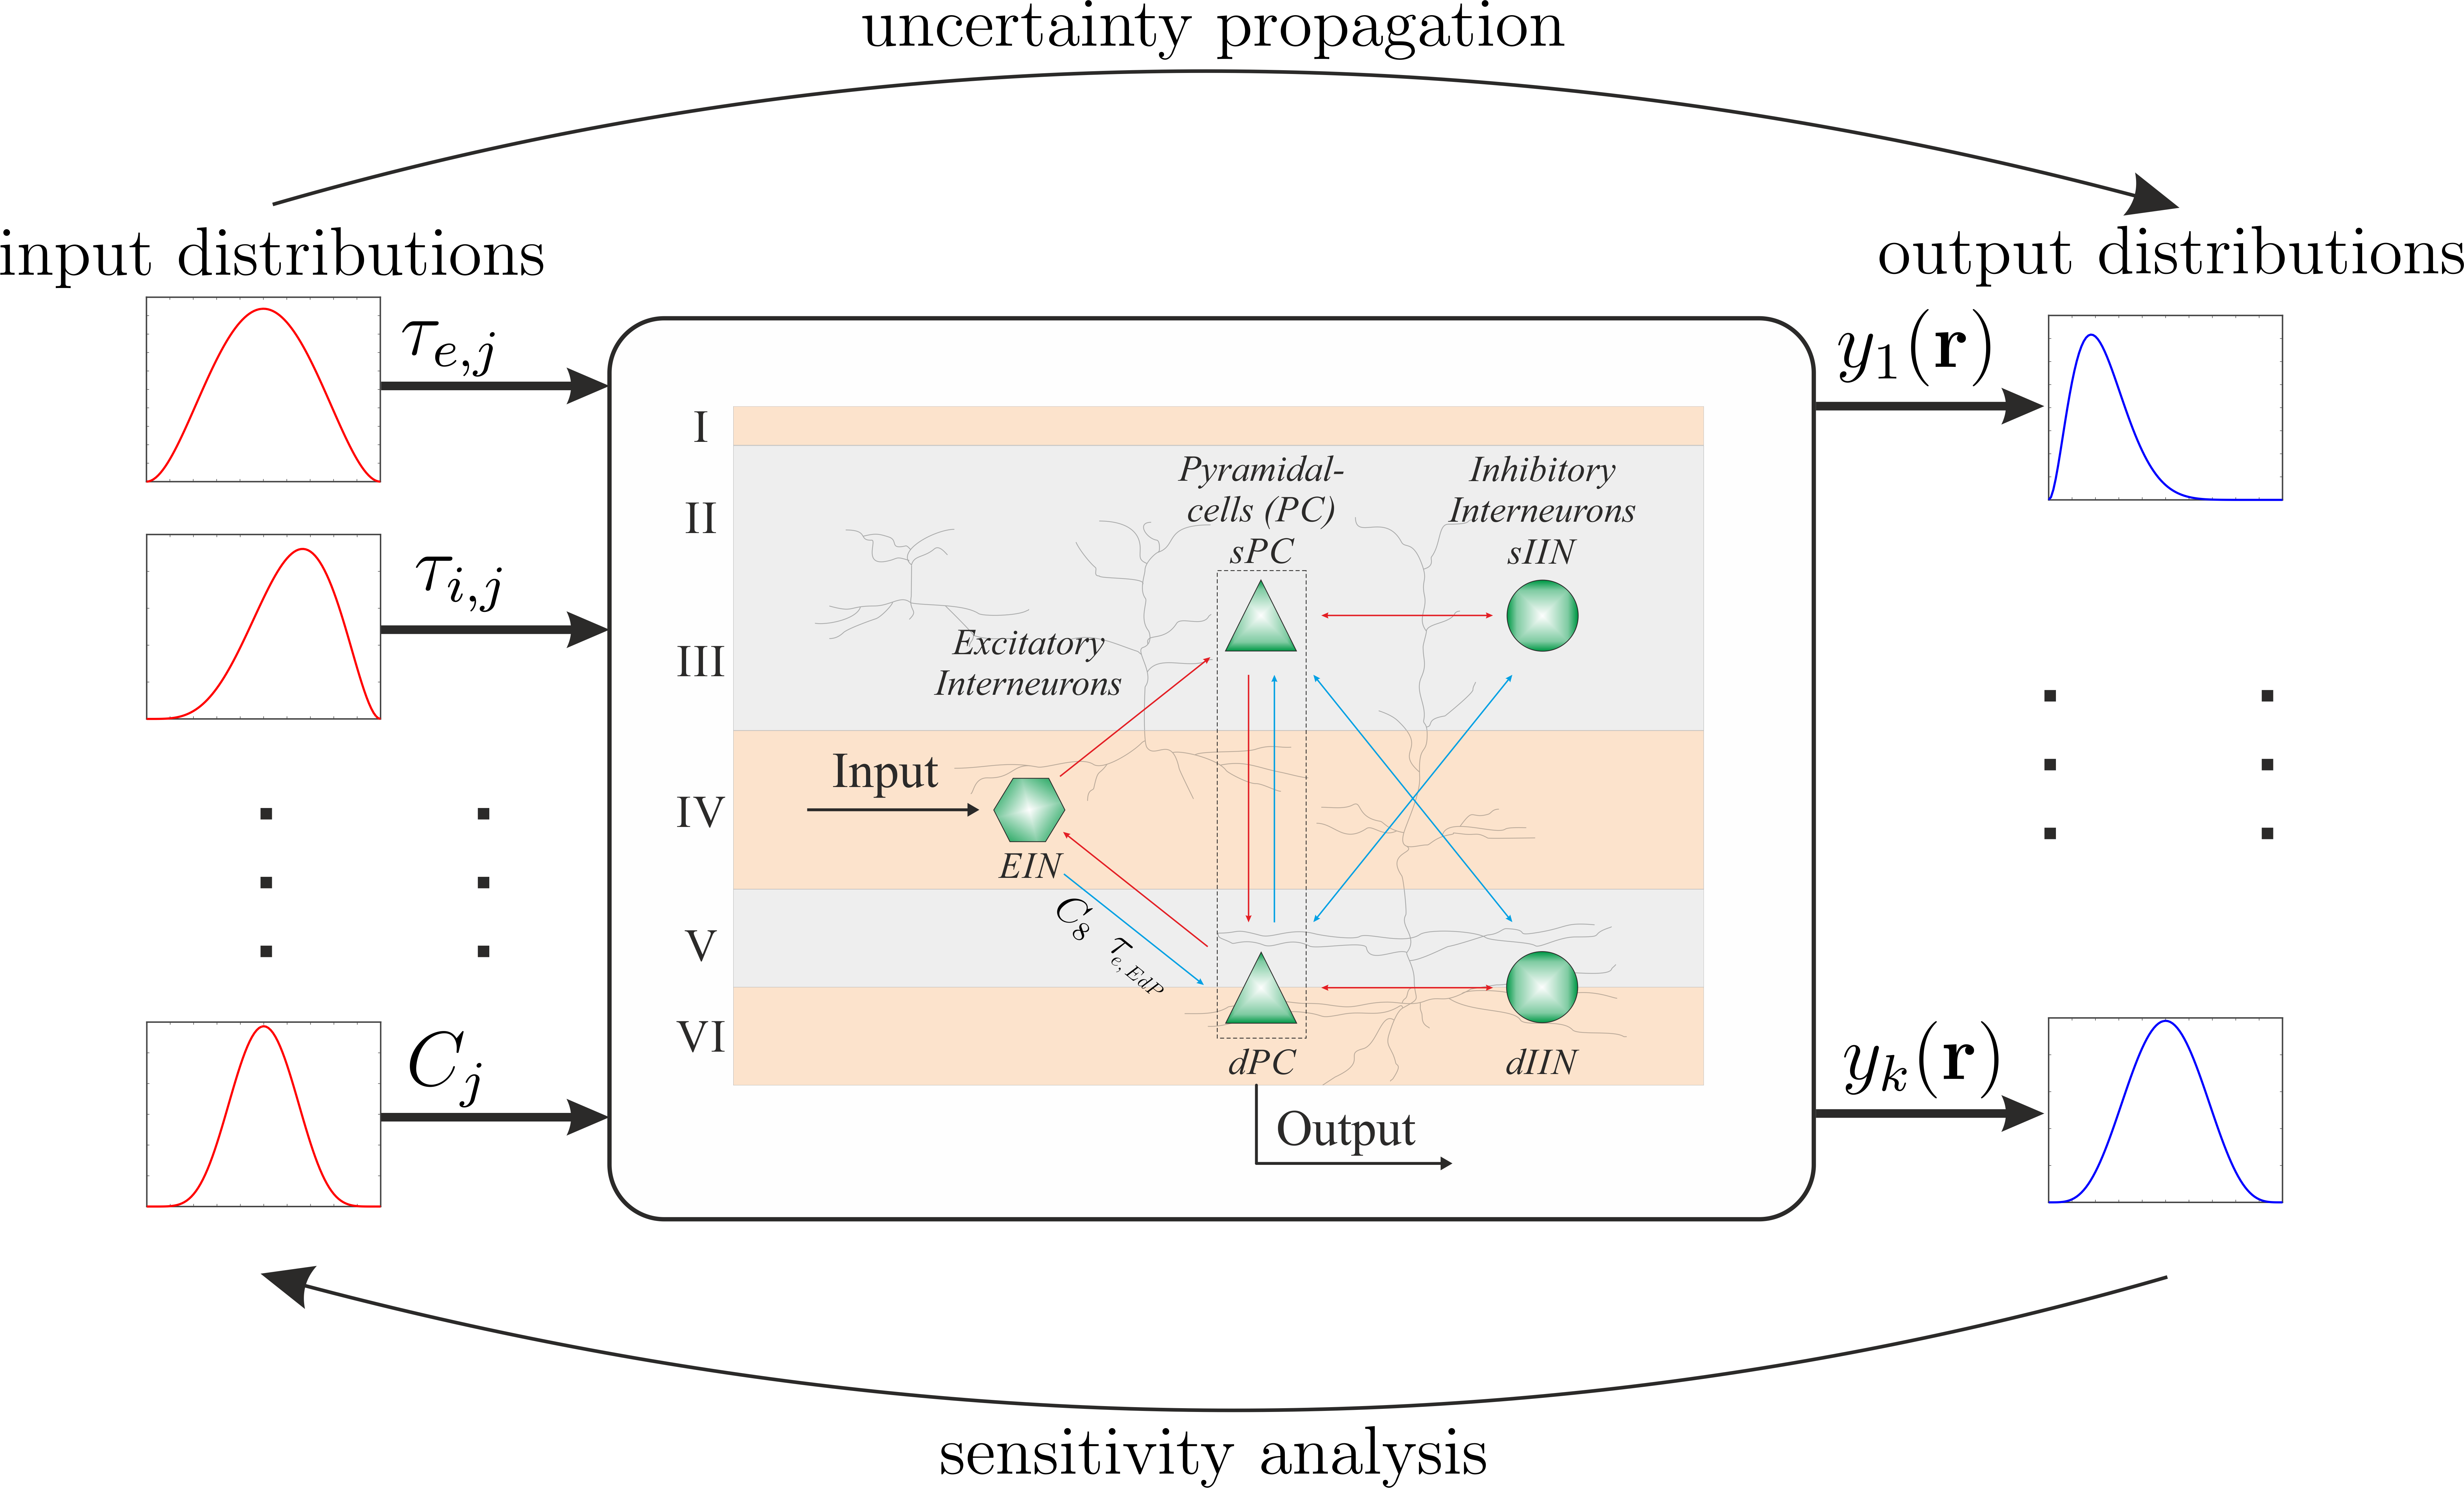



### Lookout: Uncertainty Analysis of the 3-population Montbrio circuit:

In [4]:
import pygpc
import h5py
import os
import matplotlib.pyplot as plt

fn = os.path.join(os.path.split(pygpc.__path__[0])[0], "tutorials", "datasets", "PyRates_CNS_GPC")

# load gpc object
gpc = pygpc.read_gpc_pkl(fn + ".pkl")

# load gpc coefficients
coeffs = [None, None]
with h5py.File(fn + ".hdf5", "r") as f:
    coeffs[0] = f["coeffs/dom_0"][:]
    coeffs[1] = f["coeffs/dom_1"][:]

In [5]:
coordinates, samples = gpc.get_samples(coeffs=coeffs, n_samples=1e3)

In [6]:
mean = gpc.get_mean(samples)
print("Mean: {}".format(mean))

Mean: [[0.24802939]]


In [7]:
std = gpc.get_std(samples)
print("Std: {}".format(std))

Std: [[0.33532912]]


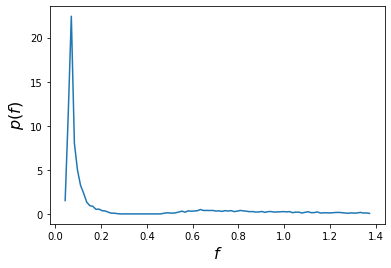

In [8]:
pdf_x, pdf_y = gpc.get_pdf(coeffs, n_samples=1e4)
plt.plot(pdf_x, pdf_y)
plt.xlabel("$f$", fontsize=16);
plt.ylabel("$p(f)$", fontsize=16);

In [9]:
sobol, sobol_idx, _ = gpc.get_sobol_indices(coeffs, n_samples=1e3)

labels = list(gpc.problem.parameters_random.keys())

for i in range(len(sobol_idx)):
    print(str([labels[j] for j in sobol_idx[i]]) + f": {sobol[i]}")

['w_iin_pc']: [0.43555814]
['w_ein_pc', 'w_iin_pc']: [0.38765341]
['w_ein_pc']: [0.19599552]


In [10]:
global_sens = gpc.get_global_sens(coeffs, n_samples=1e3)

labels = list(gpc.problem.parameters_random.keys())

for i in range(len(global_sens)):
    print(labels[i] + f": {global_sens[i]}")

w_ein_pc: [0.12276733]
w_iin_pc: [-0.18347224]


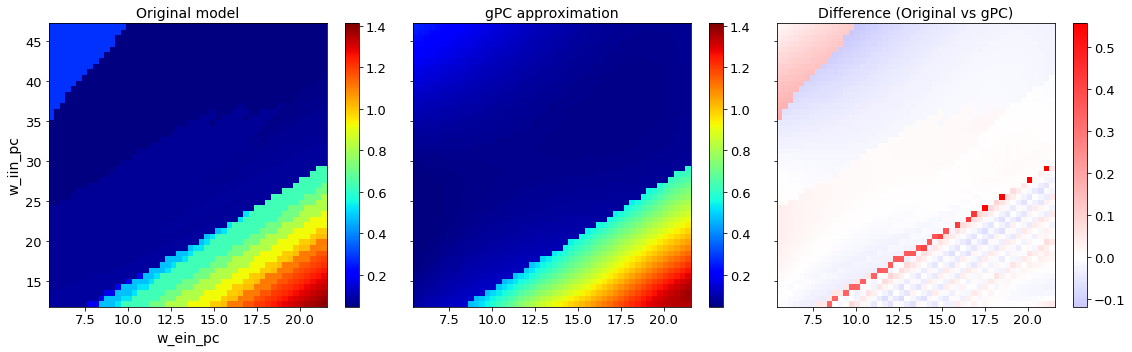

In [11]:
# load validation set
with h5py.File(fn + "_validation.hdf5", "r") as f:
    val_coords_norm = f["grid/coords_norm"][:]
    val_coords = f["grid/coords"][:]
    val_results = f["model_evaluations/original_all_qoi"][:]

# Validate gPC vs original model function
pygpc.validate_gpc_plot(gpc=gpc,
                        coeffs=coeffs,
                        random_vars=["w_ein_pc", "w_iin_pc"],
                        coords=val_coords,
                        data_original=val_results,
                        output_idx=0,
                        fn_out= None,
                        n_cpu=0)

### Back to the roots: Uncertainty analysis using Monte Carlo methods
In order to determine the statistical information of the output quantities of a system, such as the mean or the variance, one of the most common methods is Monte Carlo sampling (MC). The MC method is based on repetitive calculations of the forward model, while defining the random inputs according to their probability distributions. This results in an ensemble of solutions from which statistical properties can be derived. However, a large number of simulations is needed due to the slow convergence rate of the MC method. The mean for example converges with $1/\sqrt{N}$, where $N$ is the number of deterministic forward calculations. This limits the applicability to problems with low computational cost.

Hence, the whole UQ problem reduces to find the *unknown* transfer function (grey box) from which we can infer all necessary information (statistics, sensitivities, etc)

### Example:
Three-dimensional test function of Ishigami.
$$
y = \sin(x_1) + a \sin(x_2)^2 + b x_3^4 \sin(x_1)
$$
The Ishigami function of Ishigami & Homma (1990) is used as an example for uncertainty and sensitivity analysis methods, because it exhibits strong nonlinearity and nonmonotonicity. It also has a peculiar dependence on $x_3$, as described by Sobol' & Levitan (1999). The values of a and b used by Crestaux et al. (2007) and Marrel et al. (2009) are: a = 7 and b = 0.1.

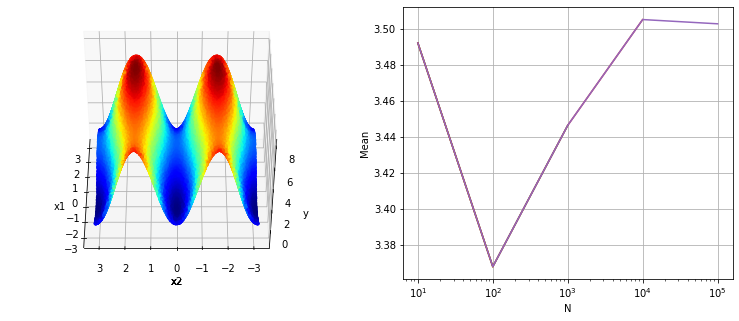

In [3]:
import pygpc
import time
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

# Parameters
p = dict()
p["x1"] = (np.random.rand(int(1e5))-0.5)*2*np.pi
p["x2"] = (np.random.rand(int(1e5))-0.5)*2*np.pi
p["x3"] = np.zeros(p["x1"].shape)
p["a"] = 7
p["b"] = 0.1

# Model
model = pygpc.testfunctions.Ishigami().set_parameters(p)

# Run simulations
y = model.simulate()

# Plot results
fig = plt.figure(figsize=[13, 5])

N = np.logspace(1, 5, 5).astype(int)
mean = []

for i in range(len(N)):
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(p["x1"][:N[i]], 
                p["x2"][:N[i]], 
                y[:N[i]], 
                s=4, c=y[0:N[i]].flatten(), cmap="jet")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    ax1.set_zlabel("y")
    ax1.view_init(elev=45, azim=180)
        
    ax2 = fig.add_subplot(122)
    mean.append(np.mean(y[:N[i]]))
    ax2.plot(N[:i+1], mean)
    ax2.set_xscale("log")
    ax2.grid(True)
    ax2.set_xlabel("N")
    ax2.set_ylabel("Mean")
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    time.sleep(3)

### How can we do better?
### Part 2: Generalized Polynomial Chaos
The primary focus of this tutorial rests on spectral methods, which are based on the determination of a functional dependence between the probabilistic in- and output of a system by means of a series of suitable selected functionals. The practical realization of spectral methods can be further subdivided into *intrusive* and **non-intrusive** approaches. Intrusive approaches are based on Galerkin methods, where the governing equations have to be modified to incorporate the probabilistic character of the model parameters. This includes the determination of the stochastic weak form of the problem according to the given uncertainties [LeMaitre.2010]. On the contrary,  non-intrusive approaches are based on a reduced sampling of the probability space without any modification of the deterministic solvers. Those methods are more flexible and thus more suitable for universal application. Typical applications can be found in the fields of computational fluid dynamics [Knio.2006, Xiu.2003, Hosder.2006], heat transfer [Wan.2004, Xiu.2003b], multibody dynamics [Sandu.2006, Sandu.2006b], robust design optimization [Zein.2013] or in biomedical engineering [Saturnino.2019, Weise.2015, Codecasa.2016]. During the last years, spectral approaches are becoming increasingly popular. However, those are not a reference tool yet and still unknown for many people. For that reason, particular emphasis is placed to describe the method and to further elucidate the principle by means of examples.


### The gPC expansion
The basic concept of the gPC is to find a functional dependence between the random variables ${\xi}$ and the solutions $y(\mathbf{r},{\xi})$ by means of an orthogonal polynomial basis $\Psi({\xi})$. In its general form, it is given by: 

$$
y(\mathbf{r},{\xi}) = \sum_{\mathbf{\alpha}\in\mathcal{A}(\mathbf{p})} u_{\mathbf{\alpha}}(\mathbf{r}) \Psi_{\mathbf{\alpha}}({\xi}).
$$

The terms are indexed by the multi-index  $\mathbf{\alpha}=(\alpha_0,...,\alpha_{d-1})$, which is a $d$-tuple of non-negative integers $\mathbf{\alpha}\in\mathbb{N}_0^d$. The sum is carried out over the multi-indices, contained in the set $\mathcal{A}(\mathbf{p})$. The composition of the set depends on the type of expansion and is parameterized by a parameter vector $\mathbf{p}$, which will be explained in a later part of this section.

The function $\Psi_{\mathbf{\alpha}}({\xi})$ are the joint polynomial basis functions of the gPC. They are composed of polynomials $\psi_{\alpha_i}(\xi_i)$.

$$
\Psi_{\mathbf{\alpha}}({\xi}) = \prod_{i=1}^{d} \psi_{\alpha_i}(\xi_i)
$$

The polynomials $\psi_{\alpha_i}(\xi_i)$ are defined for each random variable separately according to the corresponding pdf $p_i(\xi_i)$. They have to be chosen to ensure orthogonality. The set of polynomials for an optimal basis of continuous probability distributions is derived from the Askey scheme [Askey.1985]. The index of the polynomials denotes its order (or degree). In this way, the multi-index $\mathbf{\alpha}$ corresponds to the order of the individual basis functions forming the joint basis function.

| Type      | Distribution | Orthogonal polynomials | Range               |
|-----------|--------------|------------------------|---------------------|
|continuous | uniform      | Legendre               | $(a,b)$             |
|continuous | beta         | Jacobi                 | $(a,b)$             |
|continuous | gaussian     | Hermite                | $(-\infty,+\infty)$ |
| discrete  | poisson      | Charlier               | $(0,1,...)$         |

### Random parameters
The $d$ parameters of interest, which are assumed to underlie a distinct level of uncertainty, are modeled as a $d$-variate random vector denoted by $\mathbf{\xi} = (\xi_1, \, \xi_2, \, ... \xi_d)$. It is defined in the probability space $(\Theta, \Sigma, P)$. The event or random space $\Theta$ contains all possible events. $\Sigma$ is a $\sigma$-Algebra over $\Theta$, containing sets of events, and $P$ is a function assigning the probabilities of occurrence to the events. The number of random variables $d$ determines the *dimension* of the uncertainty problem. It is assumed that the parameters are statistically mutually independent from each other. In order to perform a gPC expansion, the random variables must have a finite variance, which defines the problem in the $L_2$-Hilbert space.<br />
The probability density function (pdf) $p_i(\xi_i)$, with $i=1,...,d$, has to be defined for each random variable $\xi_i$. <br />
Currently, **pygpc** supports:

#### $\beta$ distributed random variables:


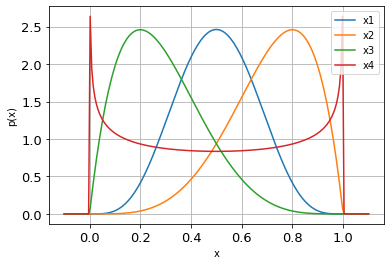

In [13]:
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[5, 5], pdf_limits=[0, 1])
parameters["x2"] = pygpc.Beta(pdf_shape=[5, 2], pdf_limits=[0, 1])
parameters["x3"] = pygpc.Beta(pdf_shape=[2, 5], pdf_limits=[0, 1])
parameters["x4"] = pygpc.Beta(pdf_shape=[0.75, 0.75], pdf_limits=[0, 1])
ax = parameters["x1"].plot_pdf()
ax = parameters["x2"].plot_pdf()
ax = parameters["x3"].plot_pdf()
ax = parameters["x4"].plot_pdf()
ax.legend(["x1", "x2", "x3", "x4"])

#### *Uniform* distributed random variables:

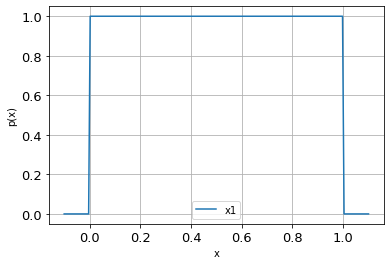

In [14]:
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[0, 1])
ax = parameters["x1"].plot_pdf()
ax.legend(["x1"])

#### *Normal* distributed random variables:

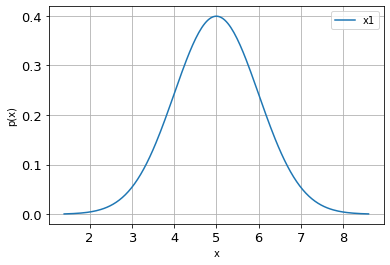

In [15]:
parameters = OrderedDict()
parameters["x1"] = pygpc.Norm(pdf_shape=[5, 1])
ax = parameters["x1"].plot_pdf()
ax.legend(["x1"])

#### Probabilists Hermite polynomials $He_n(x)$:
$$He_0(x) = 1$$
$$He_1(x) = x$$
$$He_2(x) = x^2-1$$
$$He_3(x) = x^3-3x$$
$$...$$

#### Jacobi polynomials for $\alpha=q-1$ and $\beta=p-1$
$$P_0^{(0,0)}(x) = 1$$
$$P_1^{(0,0)}(x) = x$$
$$P_2^{(0,0)}(x) = \frac{1}{2}(3x^2-1)$$
$$P_3^{(0,0)}(x) = \frac{1}{2}(5x^3-3x)$$
$$...$$

### Orthogonality
Orthogonality of the polynomial basis for the uni-variate case is given by:

$$
\int_{\Theta}\psi_m(\xi_i)\psi_n(\xi_i)p_i(\xi_i)\,\textrm{d}\xi_i = \delta_{mn}\left\langle \psi_m^2 \right\rangle
$$

The orthogonality also holds for the joint polynomial basis functions $\Psi_{\mathbf{\alpha}}({\xi})$ even if different families of orthogonal polynomials are considered in the gPC, which means that an individual pdf can be assigned to each random variable:

$$\int_{\Theta} \Psi_{\mathbf{m}} \Psi_{\mathbf{n}} p({\xi})\,\textrm{d}{\xi} = \prod_{i=1}^{d}\int_{\Theta}\psi_{m_i}(\xi_i)\psi_{n_i}(\xi_i)p_i(\xi_i) = \prod_{i=1}^{d} \delta_{m_i n_i}\left\langle\psi_{m_i}^2\right\rangle = \delta_{\mathbf{mn}}\left\langle\Psi_{\mathbf{m}}^2\right\rangle$$

Where $\mathbf{m}=(m_1,\,...,\,m_d)$ and $\mathbf{n}=(n_1,\,...,\,n_d)$ are multi-indices. As soon as one pair of indices is not equal $m_i \neq n_i$, the right hand side vanishes and orthogonality is ensured. The only non-vanishing combination is when $\mathbf{m}=\mathbf{n}$, i.e. ($m_1=n_1,\,...,\, m_d=n_d$).

#### Test-problem (Ishigami):

In [7]:
# define model
model = pygpc.testfunctions.Ishigami()

# define parameters
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x2"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x3"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])

# define problem
problem = pygpc.Problem(model, parameters)

### Set of basis functions
#### Total-order gPC
In general, the set $\mathcal{A}(\mathbf{p})$ of multi-indices can be freely chosen according to the problem under investigation. In the following figures, the blue boxes correspond to polynomials included in the gPC expansion. The coordinates of the boxes correspond to the multi-indices $\mathbf{\alpha}$, which correspond to the polynomial degrees of the individual basis functions forming the joint basis functions.
For a total-order gPC, the number of basis functions, and hence, coefficients to determine, increases exponentially in this case $N_c=(P+1)^d$.

In [6]:
# total-order gPC
basis = pygpc.Basis()
basis.init_basis_sgpc(problem=problem,
                      order=[5, 5, 5],
                      order_max=15,
                      order_max_norm=1,
                      interaction_order=3)

basis.plot_basis(dims=[0, 1, 2])

NameError: name 'problem' is not defined

#### Maximum-order gPC
In practical applications, the more economical maximum total order gPC is preferably used. In this case, the set $\mathcal{A}(p_g)$ includes all polynomials whose total order does not exceed a predefined value $P_g$. 
$$
\mathcal{A}(p_g) = \left\{ \mathbf{\alpha} \, : \, \sum_{i=1}^{d} \alpha_i \leq p_g \right\} = \left\{ \mathbf{\alpha} \, : \lVert \mathbf{\alpha} \rVert_1  \leq p_g \right\}
$$
This results in a reduced set of basis functions and is termed maximum order gPC. The number of multi-indices, and hence, the dimension of the space spanned by the polynomials, is [Eldred.2009]:
$$
N_c = \binom{d+p_g}{d} = \frac{(d+p_g)!}{d!p_g!}.
$$

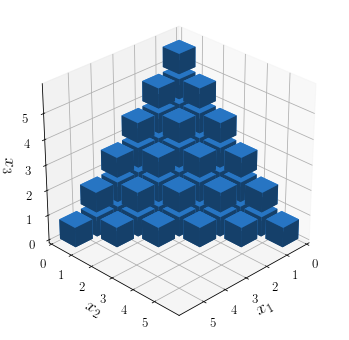

In [18]:
# maximum-order gPC
basis = pygpc.Basis()
basis.init_basis_sgpc(problem=problem,
                      order=[5, 5, 5],
                      order_max=5,
                      order_max_norm=1,
                      interaction_order=3)

basis.plot_basis(dims=[0, 1, 2])

#### Reduced-basis gPC 
The concept of the *maximum-order* gPC is extended by introducing three new parameters:
- the *univariate* expansion order $\mathbf{p}_u = (p_{u,1},...,p_{u,d})$ with $p_{u,i}>p_g \forall i={1,...,d}$
- the *interaction order* $p_i$, limits the number of interacting parameters and it reflects the dimensionality, i.e. the number of random variables (independent variables) appearing in the basis function $\Psi_{\mathbf{\alpha}}({\xi})$: $\lVert\mathbf{\alpha}\rVert_0 \leq p_i$
- the *maximum order norm* $q$ additionally truncates the included basis functions in terms of the maximum order $p_g$ such that $\lVert \mathbf{\alpha} \rVert_{q}=\sqrt[q]{\sum_{i=1}^d \alpha_i^{q}} \leq p_g$

Those parameters define the set $\mathcal{A}(\mathbf{p})$ with $\mathbf{p} = (\mathbf{p}_u,p_i,p_g, q)$

The reduced set $\mathcal{A}(\mathbf{p})$ is then constructed by the following rule:

$$
\mathcal{A}(\mathbf{p}) := \left\{ \mathbf{\alpha} \in \mathbb{N}_0^d\, : (\lVert \mathbf{\alpha} \rVert_q  \leq p_g \wedge \lVert\mathbf{\alpha}\rVert_0 \leq p_i) \vee (\lVert \mathbf{\alpha} \rVert_1  \leq p_{u,i} \wedge \lVert\mathbf{\alpha}\rVert_0 = 1, \forall i \in \{1,...,d\}) \right\} 
$$

It includes all elements from a total order gPC with the restriction of the interaction order $P_i$. Additionally, univariate polynomials of higher orders specified in $\mathbf{P}_u$ may be added to the set of basis functions.

- bias variance trade-off

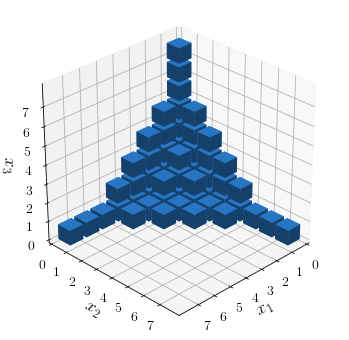

In [9]:
# reduced basis gPC
basis = pygpc.Basis()
basis.init_basis_sgpc(problem=problem,
                      order=[7, 7, 7],
                      order_max=7,
                      order_max_norm=0.7,
                      interaction_order=3)

basis.plot_basis(dims=[0, 1, 2])

#### Adaptive basis
The basic problem in gPC is to find a suitable basis while reducing the number of necessary forward simulations to determine the gPC coefficients!

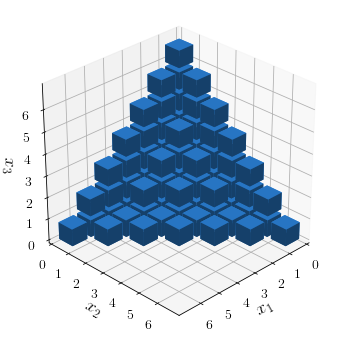

In [11]:
import pygpc
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from collections import OrderedDict

# Adaptive basis gPC
basis_order = np.array([-1, 0])
interaction_order = 3
order_max_norm = 1

# define model
model = pygpc.testfunctions.Ishigami()

# define parameters
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x2"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x3"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])

# define problem
problem = pygpc.Problem(model, parameters)
basis = pygpc.Basis()

for i in range(15):    
    # increment basis
    basis_order [0], basis_order[1] = pygpc.increment_basis(order_current=basis_order[0],
                                                      interaction_order_current=basis_order[1],
                                                      interaction_order_max=interaction_order,
                                                      incr=1)
    
    # set basis
    basis.init_basis_sgpc(problem=problem,
                          order=[basis_order[0]]*problem.dim,
                          order_max=basis_order[0],
                          order_max_norm=order_max_norm,
                          interaction_order=interaction_order,
                          interaction_order_current=basis_order[1])

    # plot basis
    basis.plot_basis(dims=[0, 1, 2], dynamic_plot_update=True)         

    time.sleep(0.5)    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.close()

### Determining the gPC coefficients
After constructing the polynomial basis, the corresponding gPC-coefficients $u_{\mathbf{\alpha}}(\mathbf{r})$ have to be determined for each output quantity. In this regard, the output variables are projected from the $d$-dimensional probability space $\Theta$ into the $N_c$-dimensional polynomial space $\mathcal{P}_{N_c}$. In this regard, an analytical approximation of the solutions $y(\mathbf{r},\mathbf{\xi})$ as a function of its random input parameters $\mathbf{\xi}$ is derived. This enables computational efficient investigations on its stochastics. Different methods exist to calculate the gPC-coefficients $u_{\mathbf{\alpha}}(\mathbf{r})$, whereas in the following, two different approaches are described.

#### Regression approach
In the regression approach, the gPC coefficients are estimated using the method of least squares. Assuming that the model is evaluated $N_g>N_c$ times on some grid $\mathcal{G}$, the gPC expansion can be written in matrix form as:

$$
[\mathbf{Y}] = [\mathbf{\Psi}][\mathbf{U}]
$$

The gPC-coefficients for each QOI (columns of $[\mathbf{U}]$) can then be found by using different solvers. <br />

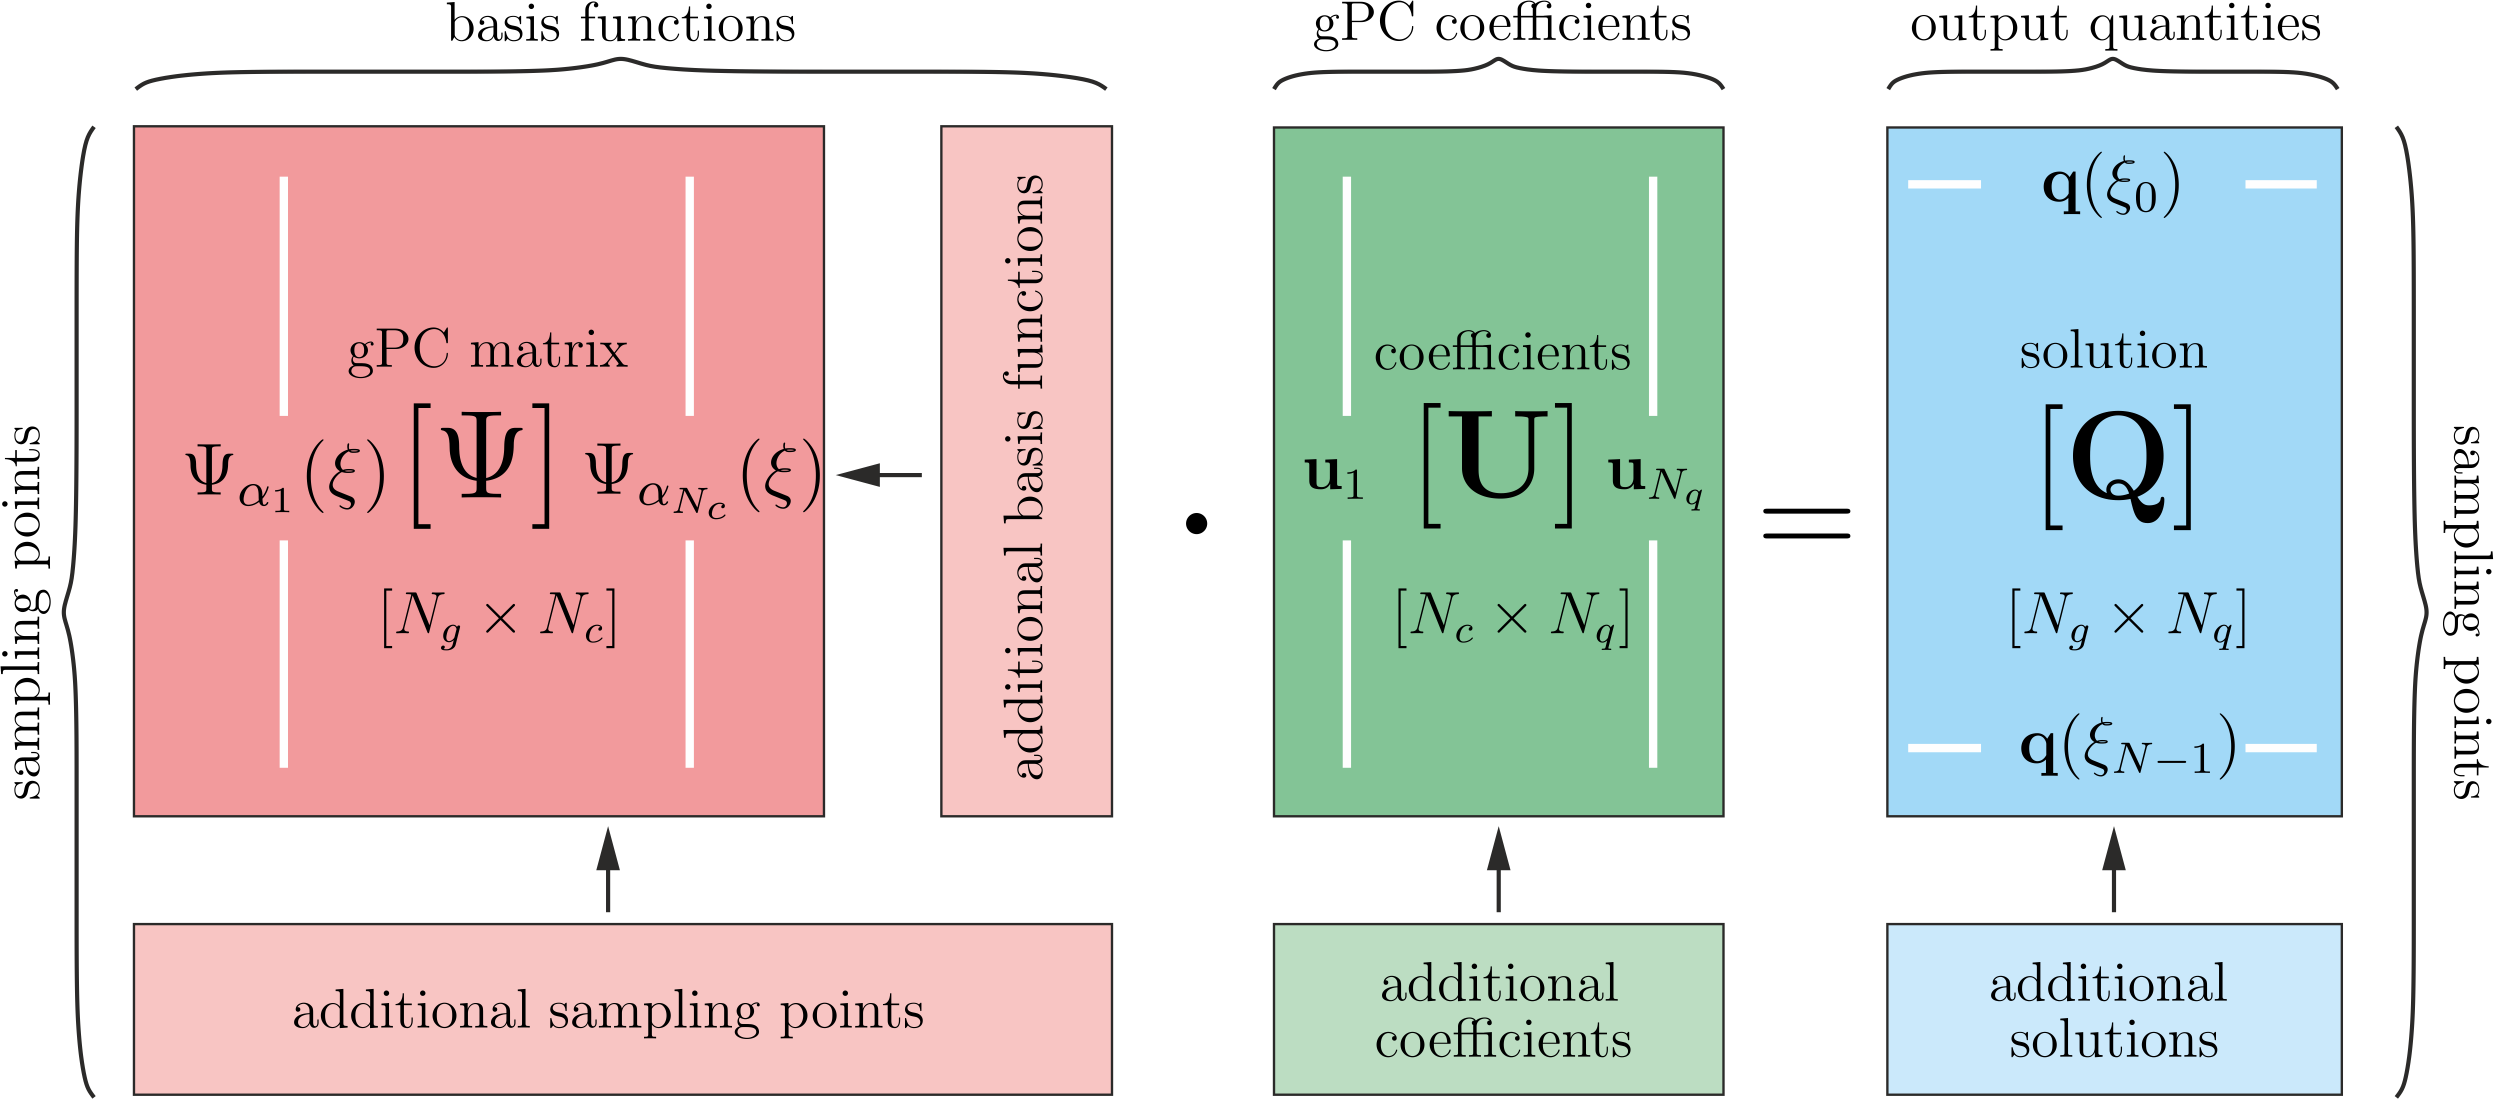

##### Moore-Penrose pseudo inverse:
Computes a "best fit" (least squares) solution to a system of linear equations that lacks a unique solution.

$$
[\mathbf{U}] = [\mathbf{\Psi}]^{+}[\mathbf{Y}]
$$

##### Least Angle Regression (LARS)
If the coefficients have a sufficiently rapid decay or if certain dimensions are dominant in an accurate reconstruction, we have a
*operative sparsity* of the approximation that leads to stable and convergent approximations. The index set $\mathcal{A}$ may have few *active* elements, allowing us to accurately reconstruct $[\mathbf{U}]$ using $N_g < N_c$ random samples (function evaluations), i.e., there exists a sparse representation for $[\mathbf{U}]$ as a linear combination of orthogonal polynomials in $\Theta$.



Here we employ compressive sampling, specifically the

Least-angle regression (LARS) is a regression algorithm for high-dimensional data, developed by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani. LARS is similar to forward stepwise regression.<br />

LARS-Lasso is a lasso model implemented using the LARS algorithm, and unlike the implementation based on coordinate descent, this yields the exact solution, which is piecewise linear as a function of the norm of its coefficients.<br />

The optimization objective for Lasso is:

$$
\frac{1}{2 N_g} \lVert y - Xw \rVert^2_2 + \alpha \lVert w \rVert_1
$$

**pygpc** makes use of of Scikit learn implementation [sklearn.linear_model.LassoLars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html). 

### Part 3: How to create your own gPC:
In order to analyze your model with **pygpc**, you have to:
- create a model class containing your model. You can find an example template in `/examples/MyModel.py`
- write a run script to set-up your problem, the desired gPC algorithm and the postprocessing. You can find an example template in `/examples/MyGPC.py`

### Setting up a model:
In order to analyze a system with **pygpc** you have to setup your model using the `AbstractModel` class of **pygpc**. This contains a method `simulate`, which is called by **pygpc** with given parameter sets stored in the dictionary `p["my_random_variable_1"]`. Those parameters can be deterministic or random, depending on their definition (see next section, when we set up the gPC problem). **pygpc** identifies which parameters are uncertain and chooses sampling points (parameter sets) according to the choosen algorithm and sets these parameters automatically.

``` Python
from pygpc.AbstractModel import AbstractModel
import numpy as np


class Ishigami(AbstractModel):
    """
    Three-dimensional test function of Ishigami.

    The Ishigami function of Ishigami & Homma (1990) [1] is used as an example
    for uncertainty and sensitivity analysis methods, because it exhibits
    strong nonlinearity and nonmonotonicity. It also has a peculiar
    dependence on x3, as described by Sobol' & Levitan (1999) [2].
    The values of a and b used by Crestaux et al. (2007) [3] 
    and Marrel et al. (2009) [4] are: a = 7 and b = 0.1.

    .. math:: y = \sin(x_1) + a \sin(x_2)^2 + b x_3^4 \sin(x_1)

    Parameters
    ----------
    p["x1"]: float or ndarray of float [n_grid]
        First parameter defined in [-pi, pi]
    p["x2"]: float or ndarray of float [n_grid]
        Second parameter defined in [-pi, pi]
    p["x3"]: float or ndarray of float [n_grid]
        Third parameter defined in [-pi, pi]
    p["a"]: float
        shape parameter (a=7)
    p["b"]: float
        shape parameter (b=0.1)

    Returns
    -------
    y: ndarray of float [n_grid x 1]
        Output data

    Notes
    -----
    .. [1] Ishigami, T., Homma, T. (1990, December). An importance quantification
       technique in uncertainty analysis for computer models. In Uncertainty
       Modeling and Analysis, 1990. Proceedings., First International Symposium
       on (pp. 398-403). IEEE.

    .. [2] Sobol', I.M., Levitan, Y.L. (1999). On the use of variance reducing
       multipliers in Monte Carlo computations of a global sensitivity index.
       Computer Physics Communications, 117(1), 52-61.

    .. [3] Crestaux, T., Martinez, J.-M., Le Maitre, O., & Lafitte, O. (2007).
       Polynomial chaos expansion for uncertainties quantification and 
       sensitivity analysis [PowerPoint slides].
       Retrieved from SAMO 2007
       website: http://samo2007.chem.elte.hu/lectures/Crestaux.pdf.

    .. [4] Marrel, A., Iooss, B., Laurent, B., & Roustant, O. (2009).
       Calculations of sobol indices for the gaussian process metamodel.
       Reliability Engineering & System Safety, 94(3), 742-751.
    """

    def __init__(self, p, context=None):
        super(Ishigami, self).__init__(p, context)

    def validate(self):
        pass

    def simulate(self, process_id=None):

        if self.p["x1"] is not np.ndarray:
            self.p["x1"] = np.array(self.p["x1"])

        if self.p["x2"] is not np.ndarray:
            self.p["x2"] = np.array(self.p["x2"])

        if self.p["x3"] is not np.ndarray:
            self.p["x3"] = np.array(self.p["x3"])
        
        y = (np.sin(self.p["x1"].flatten()) + self.p["a"] * 
             np.sin(self.p["x2"].flatten()) ** 2
             + self.p["b"] * self.p["x3"].flatten() ** 4 * 
             np.sin(self.p["x1"].flatten()))

        y = y[:, np.newaxis]

        return y
```

### Setting up your gPC:
Secondly, a script is needed to define and run the gPC. In this we define:

- the system under investigation (model)
- random parameters (problem)
- options of the gPC algorithm (algorithm)

The struture of **pygpc** is: <br />
``` Python
algorithm(problem(model))
```

This allows you to:
- easily replace the model while keeping the problem and the algorithm
- define multiple problems using the same model and algorithm (e.g. when different sets of parameters are assumed to be uncertain)
- easily replace the algorithm while keeping the problem and the model

In [22]:
import pygpc
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

# Model
model = pygpc.testfunctions.Ishigami()

# Problem
parameters = OrderedDict()
parameters["x1"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x2"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[-np.pi, np.pi])
parameters["x3"] = 0.
parameters["a"] = 7.
parameters["b"] = 0.1

problem = pygpc.Problem(model, parameters)

# gPC options
options = dict()
options["order_start"] = 5
options["order_end"] = 20
options["solver"] = "LarsLasso"
options["interaction_order"] = 2
options["order_max_norm"] = 0.7
options["n_cpu"] = 0
options["adaptive_sampling"] = True
options["gradient_enhanced"] = True
options["fn_results"] = "/home/kporzig/tmp/Ishigami_gpc"
options["eps"] = 0.0075

# define algorithm
algorithm = pygpc.RegAdaptive(problem=problem, options=options)

# run gPC algorithm
gpc, coeffs, results = algorithm.run()

Order/Interaction order: 5/2
Starting adaptive sampling:
Extending grid from 14 to 14 by 0 sampling points
Performing simulations 1 to 14
It/Sub-it: 5/2 Performing simulation 01 from 14 [==                                      ] 7.1%
Total parallel function evaluation: 0.0029942989349365234 sec
It/Sub-it: N/A/N/A Performing simulation 01 from 28 [=                                       ] 3.6%
Gradient evaluation: 0.0015492439270019531 sec
Determine gPC coefficients using 'LarsLasso' solver (gradient enhanced)...
LOOCV 01 from 14 [==                                      ] 7.1%
LOOCV 02 from 14 [=====                                   ] 14.3%
LOOCV 03 from 14 [========                                ] 21.4%
LOOCV 04 from 14 [===========                             ] 28.6%
LOOCV 05 from 14 [==============                          ] 35.7%
LOOCV 06 from 14 [=================                       ] 42.9%
LOOCV 07 from 14 [====================                    ] 50.0%
LOOCV 08 from 14 [===

LOOCV 01 from 18 [==                                      ] 5.6%
LOOCV 02 from 18 [====                                    ] 11.1%
LOOCV 03 from 18 [======                                  ] 16.7%
LOOCV 04 from 18 [========                                ] 22.2%
LOOCV 05 from 18 [===========                             ] 27.8%
LOOCV 06 from 18 [=============                           ] 33.3%
LOOCV 07 from 18 [===============                         ] 38.9%
LOOCV 08 from 18 [=================                       ] 44.4%
LOOCV 09 from 18 [====================                    ] 50.0%
LOOCV 10 from 18 [======================                  ] 55.6%
LOOCV 11 from 18 [========================                ] 61.1%
LOOCV 12 from 18 [==========================              ] 66.7%
LOOCV 13 from 18 [============================            ] 72.2%
LOOCV 14 from 18 [===============================         ] 77.8%
LOOCV 15 from 18 [=================================       ] 83.3%
LOOCV 16 fr

LOOCV 12 from 25 [===================                     ] 48.0%
LOOCV 13 from 25 [====================                    ] 52.0%
LOOCV 14 from 25 [======================                  ] 56.0%
LOOCV 15 from 25 [========================                ] 60.0%
LOOCV 16 from 25 [=========================               ] 64.0%
LOOCV 17 from 25 [===========================             ] 68.0%
LOOCV 18 from 25 [============================            ] 72.0%
LOOCV 19 from 25 [==============================          ] 76.0%
LOOCV 20 from 25 [================================        ] 80.0%
LOOCV 21 from 25 [=================================       ] 84.0%
LOOCV 22 from 25 [===================================     ] 88.0%
LOOCV 23 from 25 [====================================    ] 92.0%
LOOCV 24 from 25 [======================================  ] 96.0%
LOOCV 25 from 25 [========================================] 100.0%
LOOCV computation time: 0.45795726776123047 sec
-> relative loocv error = 1

LOOCV 11 from 25 [=================                       ] 44.0%
LOOCV 12 from 25 [===================                     ] 48.0%
LOOCV 13 from 25 [====================                    ] 52.0%
LOOCV 14 from 25 [======================                  ] 56.0%
LOOCV 15 from 25 [========================                ] 60.0%
LOOCV 16 from 25 [=========================               ] 64.0%
LOOCV 17 from 25 [===========================             ] 68.0%
LOOCV 18 from 25 [============================            ] 72.0%
LOOCV 19 from 25 [==============================          ] 76.0%
LOOCV 20 from 25 [================================        ] 80.0%
LOOCV 21 from 25 [=================================       ] 84.0%
LOOCV 22 from 25 [===================================     ] 88.0%
LOOCV 23 from 25 [====================================    ] 92.0%
LOOCV 24 from 25 [======================================  ] 96.0%
LOOCV 25 from 25 [========================================] 100.0%
LOOCV com

LOOCV 25 from 25 [========================================] 100.0%
LOOCV computation time: 6759.329064130783 sec
-> relative loocv error = 0.02681887168673355
Extending grid from 49 to 51 by 2 sampling points
Performing simulations 50 to 51
It/Sub-it: 5/2 Performing simulation 1 from 2 [====================                    ] 50.0%
Total parallel function evaluation: 0.007752418518066406 sec
It/Sub-it: N/A/N/A Performing simulation 1 from 4 [==========                              ] 25.0%
Gradient evaluation: 0.0044345855712890625 sec
Determine gPC coefficients using 'LarsLasso' solver (gradient enhanced)...
LOOCV 01 from 25 [=                                       ] 4.0%
LOOCV 02 from 25 [===                                     ] 8.0%
LOOCV 03 from 25 [====                                    ] 12.0%
LOOCV 04 from 25 [======                                  ] 16.0%
LOOCV 05 from 25 [========                                ] 20.0%
LOOCV 06 from 25 [=========                           

### Post-processing
After the gPC converged, 2 files are created:
- gpc object: `*.pkl`
- results file: `*.hdf5`

After calculating the gPC-coefficients, the statistical moments of the QOIs $y(\mathbf{r},{\xi})$ can be calculated. 

##### Mean:
The expectations $\mu(\mathbf{r})$ are given by the first gPC coefficients:
$$
\mu(\mathbf{r}) = u_{\mathbf{\alpha}_0}(\mathbf{r})\\
$$

In [23]:
mean = gpc.get_mean(coeffs)
print("Mean: {}".format(mean))

Mean: [[3.50047909]]


##### Standard deviation:
The standard deviation $\sigma(\mathbf{r})$ can be calculated by summing the remaining coefficients squared:
$$
\sigma(\mathbf{r}) = \sqrt{\sum\limits_{_{\mathbf{\alpha} \in \mathcal{A} \setminus \mathbf{a}_0} } u_{\mathbf{\alpha}}(\mathbf{r})^{2}}
$$

In [24]:
std = gpc.get_std(coeffs)
print("Std: {}".format(std))

Std: [[2.5758236]]


##### Probability density function:
The pdfs of the QOIs can be determined by applying *sampling* strategies such as Monte Carlo, Latin Hypercube or Quasi Monte Carlo sampling with $N_{\text{MC}}$ realizations. Since the gPC surrogate constitutes of simple polynomials, a large number of samples such as ${N_{\text{MC}} \approx 10^5-10^6}$ can be used with *vanishingly small computational effort* compared to direct sampling. The drawn samples can be fitted to an appropriate distribution to parametrize it for further evaluations. Additional statistical tests can be applied to proof the null-hypothesis $H_0$ between the QOI and the assumed distribution.

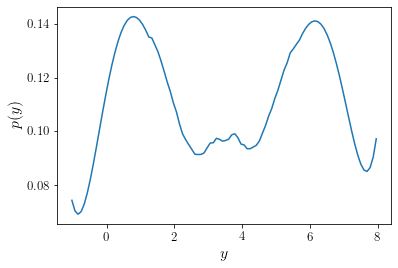

In [25]:
pdf_x, pdf_y = gpc.get_pdf(coeffs, n_samples=1e4)
plt.plot(pdf_x, pdf_y)
plt.xlabel("$y$", fontsize=16);
plt.ylabel("$p(y)$", fontsize=16);

#### Sensitivity coefficients
GPC enables comprehensive analyses to quantify the sensitivity of a system’s output with respect to its input parameters and their uncertainties, and thus to identify the parameters that contribute most to the uncertainty of the output variables. We outline two commonly used measures, namely Sobol indices and global derivative-based sensitivity coefficients.

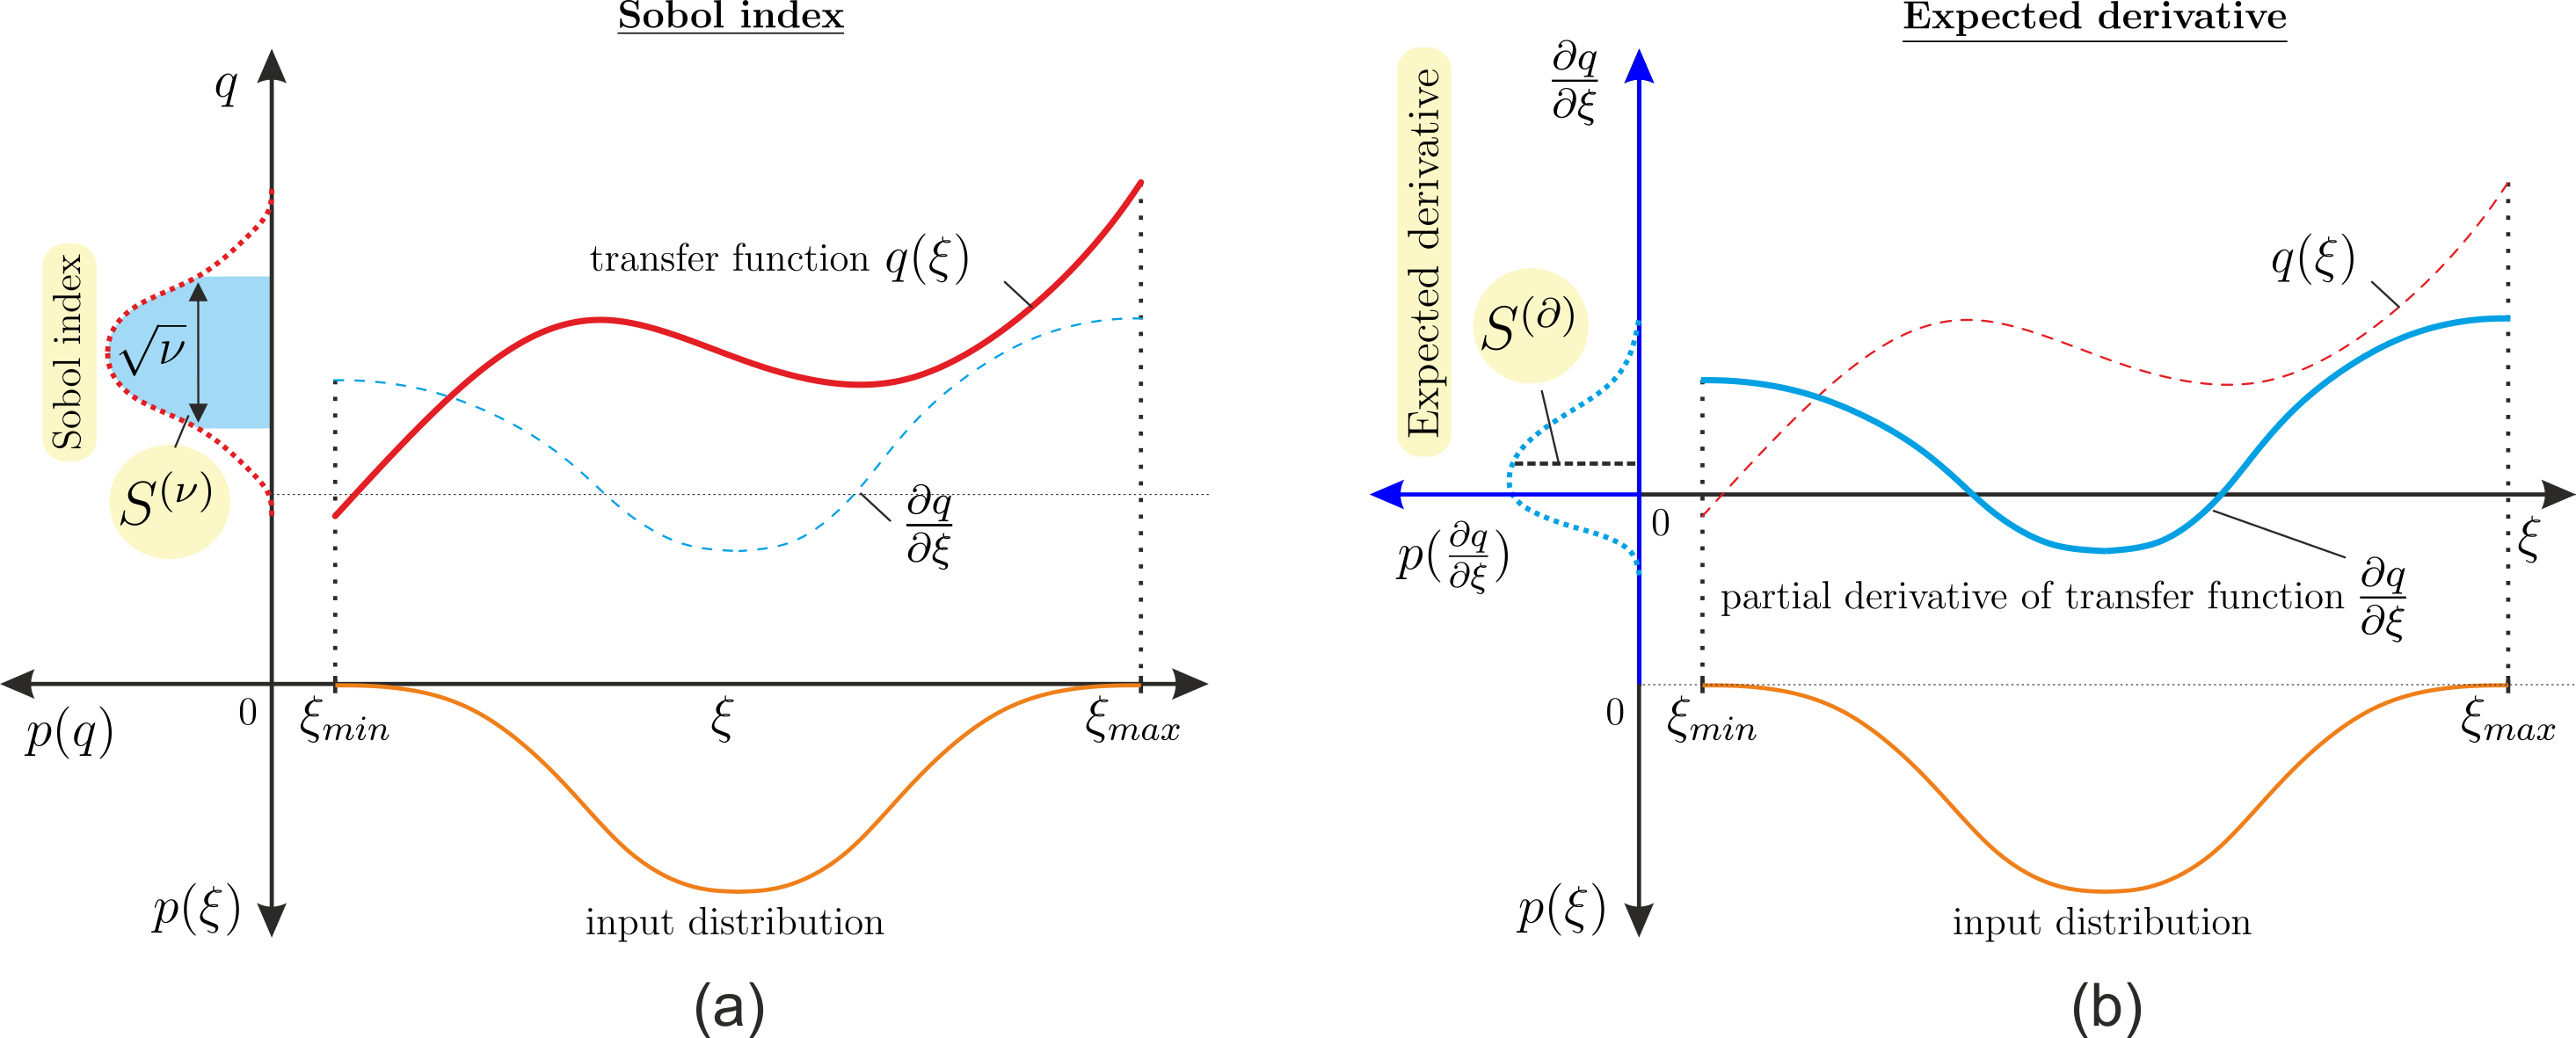

#### Sobol indices
The Sobol indices $S_i^{(\nu)}$ decompose the total variance $\sigma^2$ of the quantity of interest into components that can be attributed to individual random variables $\xi_i$ or combinations thereof [Sobol (2001), Sudret (2008)]. For each $S_i^{(\nu)}$, we summed the squared coefficients $\mathbf{u}_{\mathbf{\alpha}}^2$, whose multi-indices $\mathbf{\alpha}$ belonged to the set $\mathcal{A}_i$ with non-zero values only for the $\xi_i$ of interest.

$$
S_i^{(\nu)} = \sum\limits_{_{\mathbf{\alpha} \in \mathcal{A}_i \setminus \mathbf{a}_0} } u_{\mathbf{\alpha}}(\mathbf{r})^{2}
$$

For example, if we want the Sobol coefficient $S_1^{(\nu)}$, we select $\mathcal{A}_1=\{\{1,0,…,0\},…,\{P,0,…,0\}\}$. The Sobol indices were normalized with respect to the total variance $\sigma^2$ and consequently add up to one. In some cases however, it is advantageous to omit this normalization, especially in cases where variances and mean values of different orders of magnitude are investigated at the same time, which is the case for field distributions at, e.g., points with high or almost negligible field intensity. Importantly, Sobol indices reflect the combined effect of the uncertainty of the input parameter and the dependence between the input and output parameters. For example, a low Sobol index could be due to a low uncertainty of the input parameter, a low sensitivity of the output towards the input parameter, or both. As such, Sobol indices are well suited to identify the most important input parameters given our actual (or assumed) knowledge about them.

In [26]:
sobol, sobol_idx, _ = gpc.get_sobol_indices(coeffs)

for i in range(len(sobol_idx)):
    print("Parameter {}: {}".format(sobol_idx[i], sobol[i]))

Parameter [1]: [0.92454796]
Parameter [0]: [0.0754417]
Parameter [0 1]: [1.03333627e-05]


#### Global derivative-based sensitivity coefficients
On the other hand, the global derivative-based sensitivity coefficients $S_i^{(\partial)}$ are measures of the average change of the quantity of interest with respect to the i-th random variable. They are determined by means of the gPC-coefficients and the corresponding partial derivatives of the basis functions [Xiu (2009)]:

$$
S_i^{(\partial)} = E\left[\frac{\partial \mathbf{q}(\xi)}{\partial \xi_i}\right] = 
\sum_{\alpha \in \mathcal{A}_i)}\mathbf{u}_{\mathbf{\alpha}}\int_{\Theta}\frac{\partial \Psi_{\mathbf{\alpha}}(\xi)}{\partial \xi_i}p(\xi)\mathrm{d}\xi
$$

In [27]:
global_sens = gpc.get_global_sens(coeffs)

for i in range(len(global_sens)):
    print("Parameter {}: {}".format(i, global_sens[i]))

Parameter 0: [-0.00091652]
Parameter 1: [0.04375172]


#### The all-in-one solution:

In [28]:
# Post-process gPC and add results to .hdf5 file
pygpc.get_sensitivities_hdf5(fn_gpc=options["fn_results"],
                             output_idx=None,
                             calc_sobol=True,
                             calc_global_sens=True,
                             calc_pdf=True,
                             n_samples=1e4)

> Loading gpc object: Ishigami_gpc.pkl
> Loading gpc coeffs: /home/kporzig/tmp/Ishigami_gpc.hdf5
> Adding results to: /home/kporzig/tmp/Ishigami_gpc.hdf5


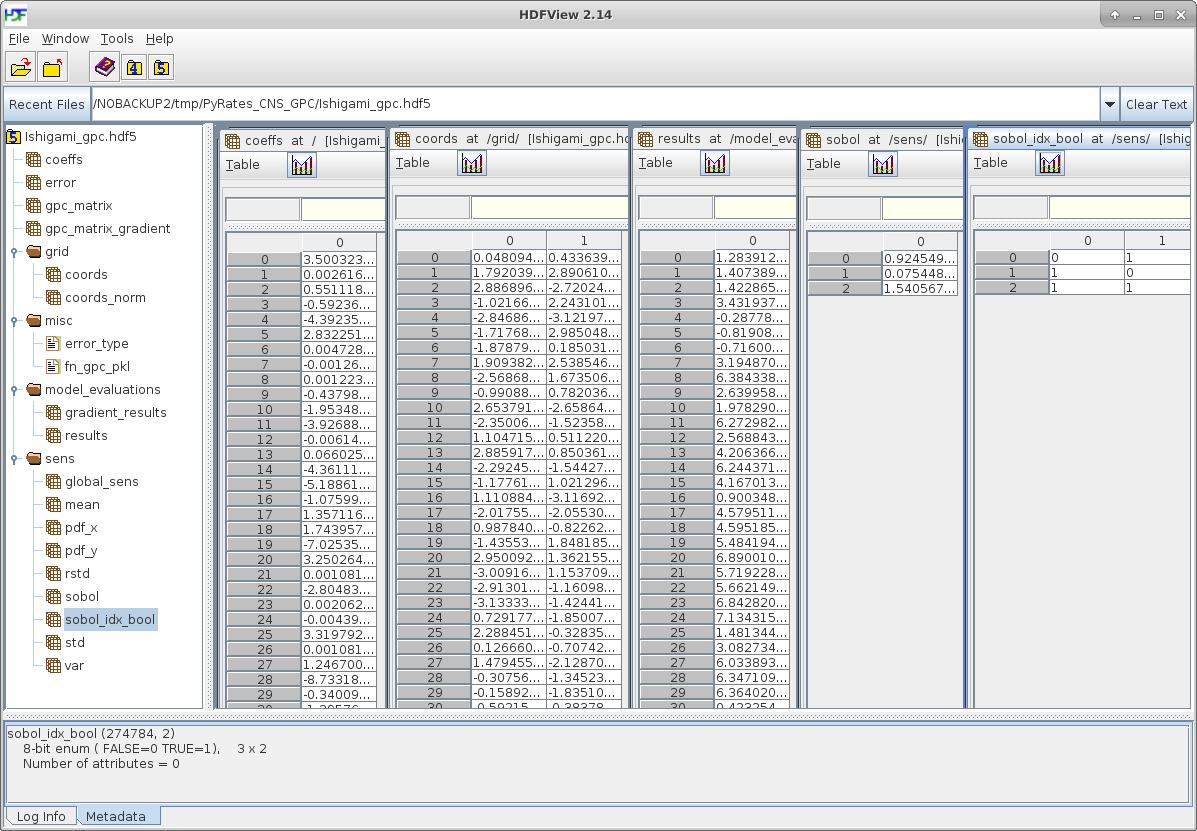

### Validation

It/Sub-it: N/A/N/A Performing simulation 0001 from 2601 [                                        ] 0.0%


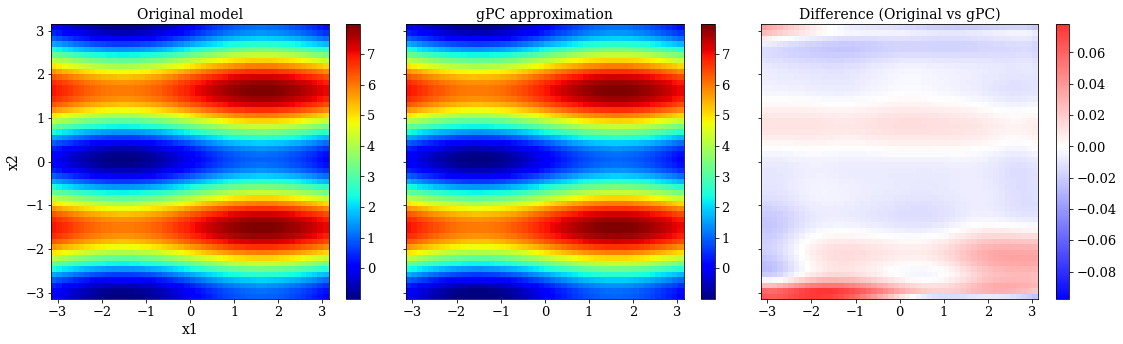

In [29]:
# Validate gPC vs original model function
pygpc.validate_gpc_plot(gpc=gpc,
                        coeffs=coeffs,
                        random_vars=["x1", "x2"],
                        n_grid=[51, 51],
                        output_idx=0,
                        fn_out= gpc.options["fn_results"] + '_validation_plot',
                        n_cpu=options["n_cpu"])

It/Sub-it: N/A/N/A Performing simulation 00001 from 10000 [                                        ] 0.0%


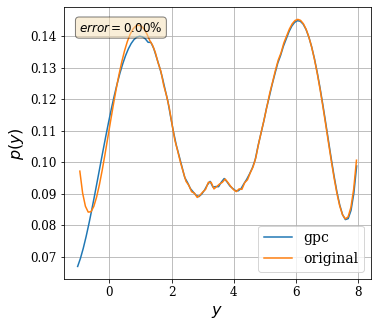

In [30]:
# Validate gPC vs original model function (Monte Carlo)
nrmsd = pygpc.validate_gpc_mc(gpc=gpc,
                              coeffs=coeffs,
                              n_samples=int(1e4),
                              output_idx=0,
                              n_cpu=gpc.options["n_cpu"],
                              fn_out=gpc.options["fn_results"] + '_validation_mc')

## Example: Analyzing a PyRates model with pygpc
### Setting up the model:

In [31]:
# -*- coding: utf-8 -*-
from pygpc.AbstractModel import AbstractModel
from pyrates.utility import grid_search
from pyrates.utility.visualization import plot_psd
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from numba import njit
import sys
import io

# auxiliary function to determine QOI
def get_psd(data, tmin=0.):
    # Compute spectrum
    try:
        dt = data.index[1] - data.index[0]
        n = data.shape[0]
        # Get closest power of 2 that includes n for zero padding
        n_two = 1 if n == 0 else 2 ** (n - 1).bit_length()

        freqs = np.linspace(0, 1 / dt, n_two)
        spec = np.fft.fft(data.loc[tmin:, :] - np.mean(data.loc[tmin:, :]), n=n_two, axis=0)
        return freqs, spec

    except IndexError:
        return np.NaN, np.NaN

    
class PyRates_CNS_Model(AbstractModel):
    """
    PyRates example model

    Parameters
    ----------
    self.p['w_ein_pc'] : ndarray of float [n_grid]
        Excitatory connectivity weight
    self.p['w_iin_pc'] : ndarray of float [n_grid]
        Inhibitory connectivity weight

    Returns
    -------
    y: ndarray of float [n_grid x n_out]
        Results of the n_out quantities of interest the gPC is conducted for
    additional_data: dict or list of dict [n_grid]
        Additional data, will be saved under its keys in the .hdf5 file during gPC simulations.
        If multiple grid-points are evaluated in one function call, return a dict for every grid-point in a list
    """

    def __init__(self, p, context):
        super(PyRates_CNS_Model, self).__init__(p, context)
        from pyrates.frontend import OperatorTemplate
        from pyrates.frontend import NodeTemplate, CircuitTemplate

        exc_syn = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) /tau',
                   'd/dt * v = (v^2 + eta + I_ext + (I_exc - I_inh)*tau - (PI*r*tau)^2) /tau',
                   'd/dt * I_exc = J*r + r_exc - I_exc/tau_exc',
                   'd/dt * I_inh =  r_inh - I_inh/tau_inh'
                   ]
        inh_syn = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) /tau',
                   'd/dt * v = (v^2 + eta + I_ext + (I_exc - I_inh)*tau - (PI*r*tau)^2) /tau',
                   'd/dt * I_exc = r_exc - I_exc/tau_exc',
                   'd/dt * I_inh = J*r + r_inh - I_inh/tau_inh'
                   ]
        variables = {'delta': {'default': 1.0},
                     'tau': {'default': 1.0},
                     'eta': {'default': -2.5},
                     'J': {'default': 0.0},
                     'tau_exc': {'default': 1.0},
                     'tau_inh': {'default': 2.0},
                     'r': {'default': 'output'},
                     'v': {'default': 'variable'},
                     'I_exc': {'default': 'variable'},
                     'I_inh': {'default': 'variable'},
                     'I_ext': {'default': 'input'},
                     'r_exc': {'default': 'input'},
                     'r_inh': {'default': 'input'},
                     }

        op_exc_syn = OperatorTemplate(name='Op_exc_syn', path=None, equations=exc_syn, variables=variables)
        op_inh_syn = OperatorTemplate(name='Op_inh_syn', path=None, equations=inh_syn, variables=variables)

        pcs = NodeTemplate(name='PCs', path=None, operators=[op_exc_syn])
        eins = NodeTemplate(name='EINs', path=None, operators={op_exc_syn: {'eta': -0.5}})
        iins = NodeTemplate(name='IINs', path=None, operators={op_inh_syn: {'tau': 2.0, 'eta': -0.5}})

        self.jrc_template = CircuitTemplate(name='jrc_template', path=None,
                                            nodes={'PCs': pcs, 'EINs': eins, 'IINs': iins},
                                            edges=[('PCs/Op_exc_syn/r', 'EINs/Op_exc_syn/r_exc',
                                                    None, {'weight': 13.5}),
                                                   ('EINs/Op_exc_syn/r', 'PCs/Op_exc_syn/r_exc',
                                                    None, {'weight': 0.8 * 13.5}),
                                                   ('PCs/Op_exc_syn/r', 'IINs/Op_inh_syn/r_exc',
                                                    None, {'weight': 0.25 * 13.5}),
                                                   ('IINs/Op_inh_syn/r', 'PCs/Op_exc_syn/r_inh',
                                                    None, {'weight': 1.75 * 13.5})]
                                            )

    def validate(self):
        pass

    def simulate(self, process_id):
        T = 500.
        dt = 1e-3
        dts = 1e-2
        ext_input = np.random.uniform(3., 5., (int(T / dt), 1))

        sys.stdout = io.StringIO()

        # run PyRates with parameter combinations
        results = grid_search(deepcopy(self.jrc_template),
                              param_grid={'w_ep': self.p['w_ein_pc'], 'w_ip': self.p['w_iin_pc']},
                              param_map={'w_ep': {'var': [(None, 'weight')],
                                                  'edges': [('EINs.0', 'PCs.0', 0)]},
                                         'w_ip': {'var': [(None, 'weight')],
                                                  'edges': [('IINs.0', 'PCs.0', 0)]}},
                              simulation_time=T, dt=dt, sampling_step_size=dts,
                              inputs={('PCs.0', 'Op_exc_syn.0', 'I_ext'): ext_input},
                              outputs={'r': ('PCs.0', 'Op_exc_syn.0', 'r')},
                              init_kwargs={'vectorization': 'nodes', 'build_in_place': False},
                              permute_grid=False,
                              backend="numpy",  # "tensorflow"
                              decorator=njit)

        y = np.zeros((len(self.p['w_ein_pc']), 1))

        # extract QOI
        for idx, (we, wi) in enumerate(zip(self.p['w_ein_pc'], self.p['w_iin_pc'])):
            # fft
            f, p = get_psd(results[we][wi], tmin=30.0)
            p = p[:int(len(p) / 2)]
            f = f[np.argmax(np.abs(p))]
            y[idx, 0] = f

        sys.stdout = sys.__stdout__

        return y




### Setting up the gPC:

In [ ]:
import os
import h5py
import pygpc
from collections import OrderedDict
from tutorials.PyRates_CNS_Model import PyRates_CNS_Model
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

fn_results = os.path.join(os.path.split(pygpc.__path__[0])[0], "tutorials", "datasets", "PyRates_CNS_GPC")

model = PyRates_CNS_Model()

# define problem (the parameter names have to be the same as in the model)
parameters = OrderedDict()
parameters["w_ein_pc"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[5.4, 21.6])
parameters["w_iin_pc"] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[11.8125, 47.25])
problem = pygpc.Problem(model, parameters)

# gPC options
options = dict()
options["method"] = "reg"
options["solver"] = "LarsLasso"
options["settings"] = None
options["order_start"] = 3
options["order_end"] = 15
options["seed"] = 1
options["projection"] = False
options["order_max_norm"] = 1.
options["interaction_order"] = 2
options["matrix_ratio"] = 2
options["n_cpu"] = 0
options["gradient_enhanced"] = False
options["gradient_calculation"] = "standard_forward"
options["error_type"] = "loocv"
options["error_norm"] = "absolute"
options["n_samples_validation"] = 1e2
options["qoi"] = 0
options["classifier"] = "learning"
options["n_samples_discontinuity"] = 10
options["adaptive_sampling"] = True
options["eps"] = 0.02
options["n_grid_init"] = 100
options["GPU"] = False
options["fn_results"] = fn_results
options["classifier_options"] = {"clusterer": "KMeans",
                                 "n_clusters": 2,
                                 "classifier": "MLPClassifier",
                                 "classifier_solver": "lbfgs"}

# define algorithm
algorithm = pygpc.MERegAdaptiveProjection(problem=problem, options=options)

# run gPC algorithm
gpc, coeffs, results = algorithm.run()

# Post-process gPC
pygpc.get_sensitivities_hdf5(fn_gpc=options["fn_results"],
                             output_idx=None,
                             calc_sobol=True,
                             calc_global_sens=True,
                             calc_pdf=True,
                             algorithm="sampling",
                             n_samples=1e4)

with h5py.File(fn_results + "_validation.hdf5") as f:
    val_coords_norm = f["grid/coords_norm"][:]
    val_coords = f["grid/coords"][:]
    val_results = f["model_evaluations/original_all_qoi"][:]

# Validate gPC vs original model function (2D-slice)
pygpc.validate_gpc_plot(gpc=gpc,
                        coeffs=coeffs,
                        random_vars=["w_ein_pc", "w_iin_pc"],
                        coords=val_coords,
                        data_original=val_results,
                        output_idx=0,
                        fn_out=options["fn_results"] + '_validation',
                        n_cpu=0)


# Validate gPC vs original model function (Monte Carlo)
nrmsd = pygpc.validate_gpc_mc(gpc=gpc,
                              coeffs=coeffs,
                              n_samples=int(1e3),
                              output_idx=0,
                              fn_out=options["fn_results"] + '_validation_mc')
